# Agent interaction analysis
## Step by step data extraction

In [1]:
# Imports
import pandas as pd
# from egg.core.interaction import Interaction
import torch
from sklearn.decomposition import PCA
from pathlib import Path
from matplotlib import pyplot as plt
from egg.zoo.pop.scripts.analysis import interaction_to_dataframe
import seaborn as sns
# used in a later part of the script :
# import numpy as np


In [2]:
# Path to your interaction files
base_path = Path("/Users/u203445/Documents/projects/EGG/")
interaction_files = ["cont_interactions_2","cont_interactions_aug"]
inters = [torch.load(base_path / file) for file in interaction_files]
df_inters = [interaction_to_dataframe(inter) for inter in inters] # <-- put interactions into dataframes which are easy to handle 
# print("available information in dataframe : \n", df_inters[0].columns)


In [3]:
# check performance scores :
for i, df_inter in enumerate(df_inters):
    acc = torch.Tensor([df_inter.batch_number % 64 == df_inter.receiver_output]).sum().item() / len(df_inter.labels)
    print(f"{interaction_files[i]} accuracy = {acc}")

cont_interactions_2 accuracy = 0.9748096955128205
cont_interactions_aug accuracy = 0.18580979567307693


## Begining of a PCA analysis
lets make an n component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\2141195783.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)][df_inter.labels.isin(_chosen_labels)]
c:\Users\u203445\Miniconda3\envs\quiche\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\2141195783.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)][df_inter.labels.isin(_chosen_labels)]
c:\Users\u203445\Miniconda3\envs\quiche\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the foll

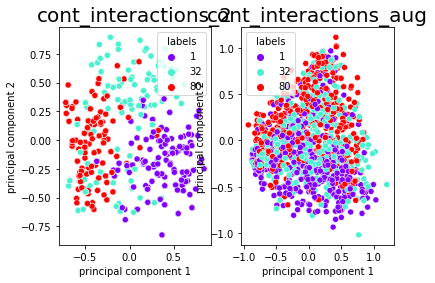

In [4]:
## Parameter Selection
# select which senders and which pretraining class labels to visualise 
_chosen_sender_index = [2,3] # _chosen_sender_index = [0,1,2,3]
_chosen_labels = [1, 32, 80] # _chosen_labels = [i for i in range(100)]
# PCA parameters
n_components=10
# PCA dimensions to show on graph
prin_comp_A = 1
prin_comp_B = 2


df_pcas = []
fig, axes = plt.subplots(1,len(df_inters)) 
# lets get those sender specific PCAs
for i,df_inter in enumerate(df_inters):
    # taking only the interactions that have the matching indexes for the chosen sender and the class labels
    selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)][df_inter.labels.isin(_chosen_labels)] 

    # PCA
    pca = PCA(n_components)
    x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
    principalComponents = pca.fit_transform(x)
    df_pca = pd.DataFrame(data = principalComponents
                , columns = [f'principal component {i+1}' for i in range(n_components)])
    ## If we were to reuse those dimensions, this is what they look like : 
    # print(df_pca[['principal component 1','principal component 2']].sample(3))

    # plotting PCA
    sns.scatterplot(df_pca[f'principal component {prin_comp_A}'],
        df_pca[f'principal component {prin_comp_B}'], 
        hue = selectedsender_interactions.set_index(df_pca.index).labels,
        ax=axes[i],
        palette='rainbow',
    ).set_title(interaction_files[i], fontsize = 20),
    
    # ax.grid()

## Some other basic things
Looking at the message distribution for intuition of where the information is hidden

In [6]:
melted_dfs = []
for df_inter in df_inters:
    # Setting each dimension column as a categoric variable (called dim) of the same type (message value)
    _melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
    _melted_df.dim.replace([f"dim_{n}" for n in range(16)],[n for n in range(16)], inplace=True)
    melted_dfs.append(_melted_df)
print(melted_dfs[0].sample(3)) # have a look here if needed 

         sender_idx  loss_idx  recv_idx  labels  receiver_output  \
799149            0         0         0      49               45   
1185957           3         0         1      10               37   
467428            3         0         1      45               36   

         batch_number  dim  message_value  
799149            429   10       0.708014  
1185957          2853   14       0.316733  
467428           3172    5       0.818833  


### Message Distribution

C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\4021152230.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders
C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\4021152230.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders


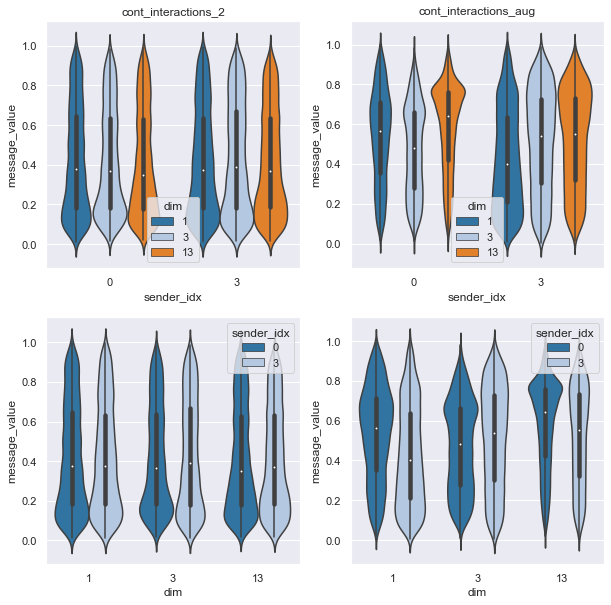

In [11]:

## Parameter Selection
# select which senders and which dimension to visualise 
_chosen_sender_index = [0,3]   # _chosen_sender_index = [0,1,2,3]
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]

sns.set(rc={'figure.figsize':(10,10)})
fig, axes = plt.subplots(2,len(melted_dfs)) 

# extract and plot
for i,melted_df in enumerate(melted_dfs):
    melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders
    sns.violinplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0,i]).set_title(interaction_files[i])
    sns.violinplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1,i])
    

# WIP : maybe add some statistical testing
# the way the violins look allow us to know where to set the saturation point were we to discretise

A quick look at the data distribution for messages in each dimension

Now we check if data distribution is modified by the class of the represented image (which it should if it wants to discriminate images)

C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\3036899652.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\3036899652.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.dim.isin(_chosen_dimensions)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\3036899652.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\3036899652.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.dim.isin(_chosen_dimensions)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_27308\3036899652.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.sender_idx.isin(_chosen_

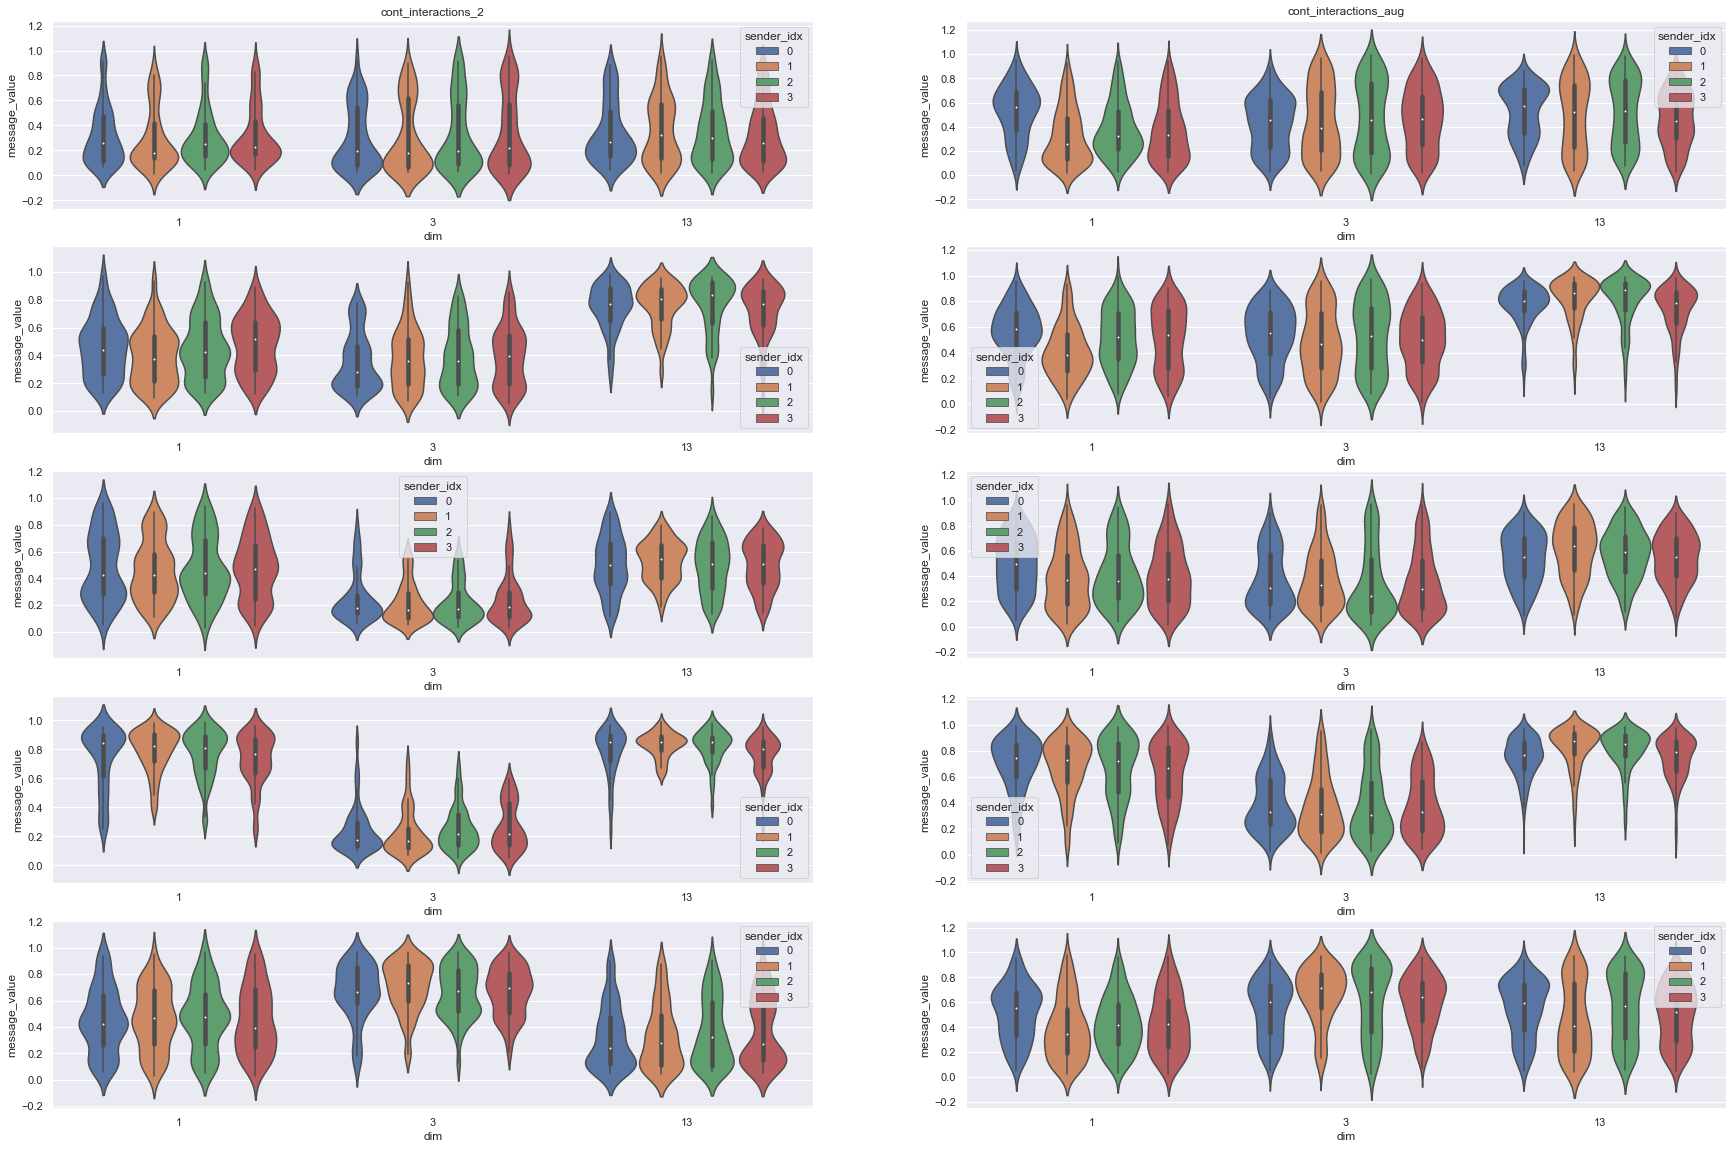

In [12]:
## Parameter Selection
# select which senders and which classes to visualise 
_chosen_sender_idxs = [0,1,2,3]
_chosen_labels = torch.randint(0,100,[5]) # three random labels
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]


sns.set(rc={'figure.figsize':(10*len(_chosen_dimensions),4*len(_chosen_labels))})
fig, axes = plt.subplots(len(_chosen_labels),len(melted_dfs)) 

for i,melted_df in enumerate(melted_dfs):
    for j, label in enumerate(_chosen_labels):
        _df = melted_df[melted_df.labels==label.item()]
        _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
        _df = _df[melted_df.dim.isin(_chosen_dimensions)]
        if len(_df) != 0:
            sns.violinplot(x=_df.dim, y=_df.message_value, hue=_df.sender_idx, ax=axes[j,i]).set_title(interaction_files[i] if j == 0 else None)

# We can see variations in dimensional distribution depending on the pre-training classes. Each sender seems to encode it in a similar manner ! 
# (which can be understood as either an approximation of the actual clustering, or perhaps the beginning of an analysis of model capacities in out-of-scope contexts)
# vit, the agent with the most different representation, is in orange (sender_idx = 1). We can see it is always using slightly different communication distributions
# vgg (blue, idx = 0) seems to be the worst tricked by data_augmentation

### Dimension correlation

In [9]:
# new imports, can't escape numpy
import numpy as np

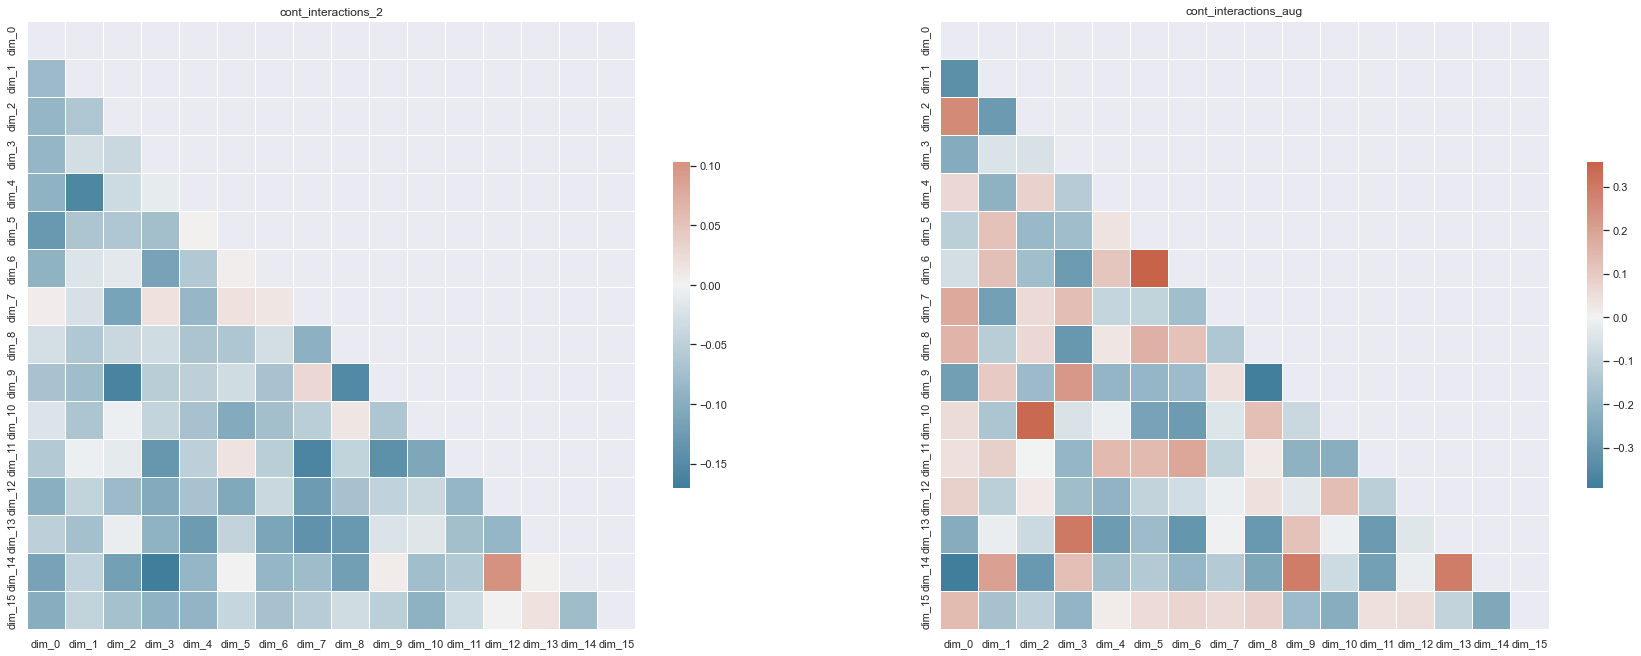

In [10]:
# Ok. Correlation between dimensions now. Are any dimensions unnecessary ?
fig, axes = plt.subplots(1,len(df_inters)) 
for i,df_inter in enumerate(df_inters):
    # Compute the correlation matrix
    # (just on the dims, not on the rest of the information in interactions)
    corr = df_inter.loc[:,df_inter.columns.str.contains('dim')].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=axes[i]).set_title(interaction_files[i])

# looks quite independant no ? with that in mind they'd all be necessary.

lets add :
* Independance of dims test
* entropy of pop languages vs one on one languages
* 